
# 🧠 Experiment 10: Solving a Markov Decision Process (MDP)

---

## 🎯 Objective
Implement a **3x4 GridWorld MDP** manually (no external RL libraries).  
We will solve it using **Value Iteration**, **Policy Iteration**, and finally **Q-Learning** (bonus task).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.2)



## 📘 Task 1: Define the GridWorld (The MDP) — (30 Marks)
- Grid size: 3x4  
- Wall: (1,1)  
- Terminal states: Goal (0,3)=+1, Pit (1,3)=-1  
- Actions = up, down, left, right  
- Living penalty = -0.04  
- Discount factor γ = 0.99  
- Transition probabilities: intended 0.8, left slip 0.1, right slip 0.1  


In [3]:
rows, cols = 3, 4
wall = (1, 1)
terminal_states = {(0, 3): 1, (1, 3): -1}
actions = ['up', 'down', 'left', 'right']
living_reward = -0.04
gamma = 0.99

action_effects = {'up': (-1, 0), 'down': (1, 0), 'left': (0, -1), 'right': (0, 1)}

def is_valid_state(state):
    r, c = state
    return not (r < 0 or r >= rows or c < 0 or c >= cols or state == wall)

def get_next_states(state, action):
    if state in terminal_states:
        return {state: 1.0}
    dirs = ['up','right','down','left']
    idx = dirs.index(action)
    probs = {action:0.8, dirs[(idx-1)%4]:0.1, dirs[(idx+1)%4]:0.1}
    next_states = {}
    for a,p in probs.items():
        dr,dc = action_effects[a]
        ns = (state[0]+dr,state[1]+dc)
        if not is_valid_state(ns): ns = state
        next_states[ns] = next_states.get(ns,0)+p
    return next_states

print("Example transitions:", get_next_states((2,0),'up'))


Example transitions: {(1, 0): 0.8, (2, 0): 0.1, (2, 1): 0.1}



## ⚙️ Task 2: Value Iteration — (30 Marks)
Compute optimal utilities by repeatedly applying Bellman update until convergence.


In [5]:
def value_iteration(threshold=1e-4, max_iter=1000):
    states=[(r,c) for r in range(rows) for c in range(cols) if (r,c)!=wall]
    U={s:0 for s in states}
    for i in range(max_iter):
        delta=0
        U_new=U.copy()
        for s in states:
            if s in terminal_states:
                U_new[s]=terminal_states[s]; continue
            best_val=-1e9
            for a in actions:
                val=sum(p*(terminal_states.get(ns,living_reward)+gamma*U[ns]) for ns,p in get_next_states(s,a).items())
                best_val=max(best_val,val)
            delta=max(delta,abs(U[s]-best_val))
            U_new[s]=best_val
        U=U_new
        if delta<threshold:
            print("Converged at iteration",i+1); break
    policy={}
    for s in states:
        if s in terminal_states: policy[s]=None; continue
        best_action=None; best_val=-1e9
        for a in actions:
            val=sum(p*(terminal_states.get(ns,living_reward)+gamma*U[ns]) for ns,p in get_next_states(s,a).items())
            if val>best_val:
                best_val = val
                best_action = a
        policy[s]=best_action
    return U,policy

U_opt,policy_opt=value_iteration()
U_opt

Converged at iteration 24


{(0, 0): 1.7588465613091657,
 (0, 1): 1.840535116283506,
 (0, 2): 1.914279247112447,
 (0, 3): 1,
 (1, 0): 1.6870402907594837,
 (1, 2): 1.4218747651717802,
 (1, 3): -1,
 (2, 0): 1.607495480566355,
 (2, 1): 1.5375696425679275,
 (2, 2): 1.4633838027649955,
 (2, 3): 1.0254989410557918}


## 🧭 Task 3: Policy Iteration — (25 Marks)
Evaluate and improve policy until stable.


In [7]:
def policy_evaluation(policy,threshold=1e-4):
    states=[(r,c) for r in range(rows) for c in range(cols) if (r,c)!=wall]
    U={s:0 for s in states}
    while True:
        delta=0
        for s in states:
            if s in terminal_states:
                U[s]=terminal_states[s]; continue
            a=policy[s]
            val=sum(p*(terminal_states.get(ns,living_reward)+gamma*U[ns]) for ns,p in get_next_states(s,a).items())
            delta=max(delta,abs(U[s]-val)); U[s]=val
        if delta<threshold: break
    return U

def policy_iteration():
    states=[(r,c) for r in range(rows) for c in range(cols) if (r,c)!=wall]
    policy={s:np.random.choice(actions) for s in states if s not in terminal_states}
    stable=False; it=0
    while not stable:
        it+=1
        U=policy_evaluation(policy)
        stable=True
        for s in states:
            if s in terminal_states: continue
            best_action=None; best_val=-1e9
            for a in actions:
                val=sum(p*(terminal_states.get(ns,living_reward)+gamma*U[ns]) for ns,p in get_next_states(s,a).items())
                if val>best_val:
                    best_val = val
                    best_action = a
            if best_action!=policy[s]:
                policy[s]=best_action; stable=False
        print("Iteration",it,"stable=",stable)
    return U,policy

U_pi,policy_pi=policy_iteration()
U_pi

Iteration 1 stable= False
Iteration 2 stable= False
Iteration 3 stable= False
Iteration 4 stable= True


{(0, 0): 1.7588457028102886,
 (0, 1): 1.8405351111064765,
 (0, 2): 1.9142792469878087,
 (0, 3): 1,
 (1, 0): 1.687038575682684,
 (1, 2): 1.4218747652445314,
 (1, 3): -1,
 (2, 0): 1.6074902102680595,
 (2, 1): 1.5375638391973245,
 (2, 2): 1.4633882760615713,
 (2, 3): 1.0255270424544962}


## 🎨 Task 4: Visualization — (10 Marks)


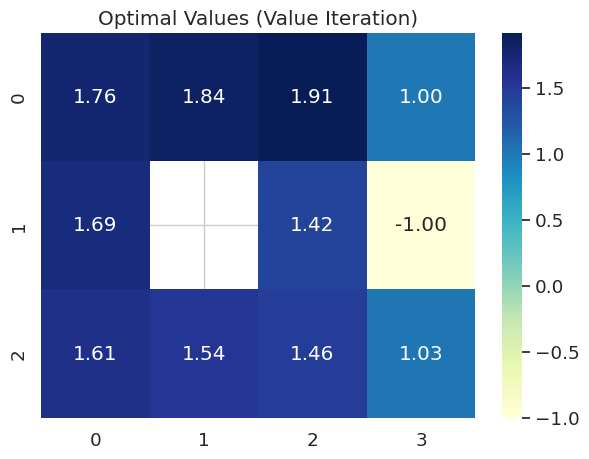

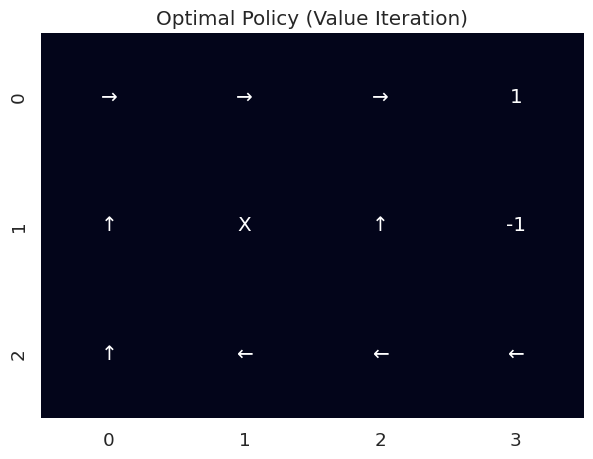

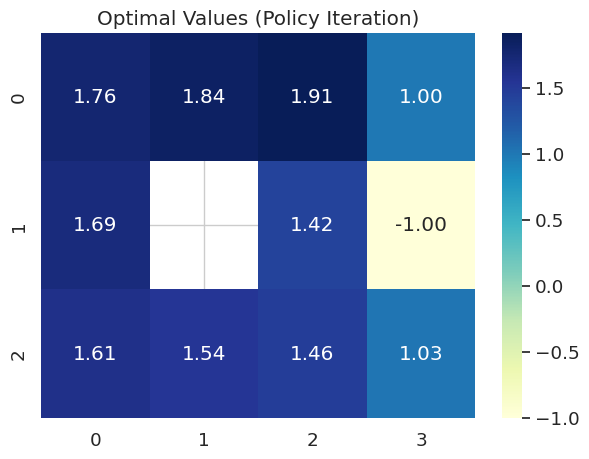

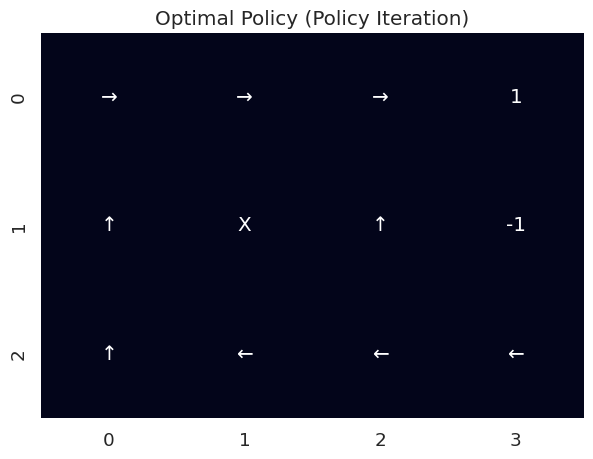

In [8]:
def plot_values(U,title):
    grid=np.zeros((rows,cols)); grid[:]=np.nan
    for (r,c),v in U.items(): grid[r,c]=v
    plt.figure(figsize=(7,5)); sns.heatmap(grid,annot=True,cmap='YlGnBu',fmt=".2f"); plt.title(title); plt.show()

def plot_policy(policy,title):
    arrows={'up':'↑','down':'↓','left':'←','right':'→'}
    grid=np.empty((rows,cols),dtype=object)
    for r in range(rows):
        for c in range(cols):
            s=(r,c)
            if s==wall: grid[r,c]='X'
            elif s in terminal_states: grid[r,c]=str(terminal_states[s])
            else: grid[r,c]=arrows[policy[s]]
    plt.figure(figsize=(7,5)); sns.heatmap(np.zeros((rows,cols)),annot=grid,fmt='',cbar=False); plt.title(title); plt.show()

plot_values(U_opt,"Optimal Values (Value Iteration)")
plot_policy(policy_opt,"Optimal Policy (Value Iteration)")

plot_values(U_pi,"Optimal Values (Policy Iteration)")
plot_policy(policy_pi,"Optimal Policy (Policy Iteration)")



## ⚡ Bonus Task: Q-Learning (Reinforcement Learning Approach)
Learn optimal policy through exploration instead of known model.


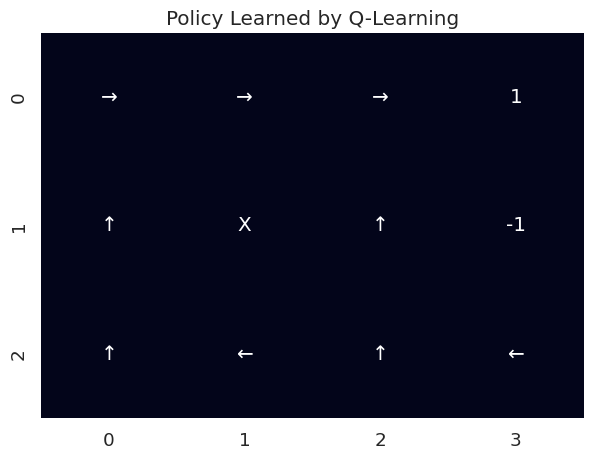

In [9]:
def q_learning(episodes=5000,alpha=0.1,gamma=0.99,epsilon=0.1):
    Q={(r,c):{a:0 for a in actions} for r in range(rows) for c in range(cols) if (r,c)!=wall}
    for ep in range(episodes):
        s=(2,0)
        while s not in terminal_states:
            a=np.random.choice(actions) if np.random.rand()<epsilon else max(Q[s],key=Q[s].get)
            next_states=get_next_states(s,a)
            next_s=list(next_states.keys())[np.random.choice(len(next_states),p=list(next_states.values()))]
            r=terminal_states.get(next_s,living_reward)
            best_next=max(Q[next_s].values()) if next_s in Q else 0
            Q[s][a]+=alpha*(r+gamma*best_next-Q[s][a])
            s=next_s
    policy={s:max(Q[s],key=Q[s].get) for s in Q}
    return Q,policy

Q,policy_q=q_learning()
plot_policy(policy_q,"Policy Learned by Q-Learning")
